In [1]:
# Testing imgage in python
# Let's generate a set of data of simple shapes and then create a deep network to classify them
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

h=128
w=128

NUM_SAMP = 5000

x_data=np.empty([NUM_SAMP*3, h, w, 3])

for i in range(NUM_SAMP):
    # Circles
    img = np.zeros((h,w,3), np.uint8)

    cv2.circle(img, (random.randint(0, h-1), random.randint(0, w-1)), random.randint(10, 50), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), -1)
    x_data[i,:,:,:] = img/255
    
    # Rectangles
    img = np.zeros((h,w,3), np.uint8)
    cv2.rectangle(img, (random.randint(0, h-1), random.randint(0, w-1)), (random.randint(0, h-1), random.randint(0, w-1)), 
                 (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), -1)
    x_data[i+NUM_SAMP,:,:,:] = img/255
    
    # Triangles
    img = np.zeros((h,w,3), np.uint8)
    
    pts = np.array([[random.randint(0, h-1), random.randint(0, w-1)], [random.randint(0, h-1), random.randint(0, w-1)], [random.randint(0, h-1), random.randint(0, w-1)]])
    cv2.fillPoly(img, [pts], (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
    x_data[i+NUM_SAMP*2,:,:,:] = img/255

y_data=np.concatenate((np.ones((1, NUM_SAMP))*0, np.ones((1, NUM_SAMP))*1, np.ones((1, NUM_SAMP))*2), axis=None)

y_data
#nplt.imshow(x_data[290, :, :, :])

array([0., 0., 0., ..., 2., 2., 2.])

In [2]:
# Now we have some made up data in x_data, y_data of basic shapes.  Split into test and validation sets and train a simple network
from sklearn.model_selection import train_test_split

x_train, x_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

In [32]:
Y_train

array([2., 0., 1., ..., 1., 1., 0.])

In [73]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf
#from keras.utils import to_categorical

import pdb

from keras.applications.vgg16 import VGG16

batch_size = 64
num_classes = 3
epochs = 15

# input image dimensions
img_rows, img_cols = w, h

input_shape = (img_rows, img_cols, 3)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))    
 
# let's define the loss function by hand
def get_cat_crossentropy_loss():
    def weighted_loss(y_true, y_pred):
        # scale preds so that the class probas of each sample sum to 1
        # Don notes: Haven't figured out why this is required.  y_pred is the output of softmax,
        # and so should already sum to 1???
        y_pred = K.print_tensor(y_pred, message="y_pred is: ")
        y_pred /= tf.reduce_sum(y_pred, -1, True)
        # manual computation of crossentropy
        # Don notes: Looks like any math has to be as a tensor in the same type
        _epsilon = tf.convert_to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
        # Don notes: We clip the values of y_pred to be away from the asymtopes of the log
        # function.  If we didn't, we will get inf or NaN values.
        y_pred = tf.clip_by_value(y_pred, _epsilon, 1. - _epsilon)
        return - tf.reduce_sum(y_true * tf.log(y_pred), -1)
    return weighted_loss
    
print(model.summary())

model.compile(loss=get_cat_crossentropy_loss(),
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (10050, 128, 128, 3)
10050 train samples
4950 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
de

In [40]:
import sys

x=np.array(([0.1, 0.9, 0.4], [0.9, 0.2, 0.3]))

y=np.array(([0, 1, 0], [1, 0, 0]))

print(np.sum(-np.log(x[y.astype('bool')])))

print(np.sum(-np.log(x+sys.float_info.epsilon)*y))

0.21072103131565256
0.21072103131565206


In [41]:
y_pred=model.predict_classes(x_test)
y_prob=model.predict_proba(x_test)

ValueError: 0 is not a valid Shape

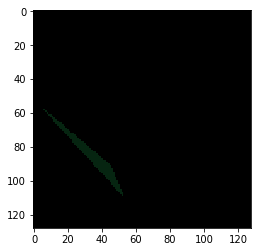

In [82]:
from enum import Enum
class Shape(Enum):
    CIRCLE = 0
    RECTANGLE = 1
    TRIANGLE = 2

img_num = random.randint(0, x_test.shape[0])

plt.imshow(x_test[img_num, :, :, :])

print(Shape(y_pred[img_num]))
print((str(y_prob[img_num][y_pred[img_num]]*100) + '%'))